In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from PIL import ImageFile
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import numpy as np
import pandas as pd
import os
import random 
from shutil import copyfile
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import re
import albumentations as albu
from albumentations.pytorch import ToTensorV2

In [4]:
import torch
import torchvision
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from sklearn.metrics import roc_auc_score
import re
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from skimage.io import imread, imsave
import skimage

torch.cuda.empty_cache()

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#change later? don't worry now
train_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [6]:
batchsize=10
import nibabel as nib

def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class NPHDataset(Dataset):
    def __init__(self, root_dir, txt_NPH, txt_Normal, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_NPH
                - img1.png
                - img2.png
                - ......
            - CT_Normal
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_NPH, txt_Normal]
        self.classes = ['NPH', 'Normal']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        # image = nib.load(img_path)
        # data = image.get_fdata()
        # rescaled = (255.0 / data.max() * (data - data.min())).astype(np.uint8)
        # image = Image.fromarray(rescaled).convert('RGB')
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1]),
                  'name' : str(self.img_list[idx][0])}
        return sample



In [7]:
    
if __name__ == '__main__':
    trainset = NPHDataset(root_dir='/home/kathy/',
                              txt_NPH='/home/kathy/NPHtrainNPH.txt',                            
                              txt_Normal='/home/kathy/NormaltrainNormal.txt',
                              transform= train_transformer)
    valset = NPHDataset(root_dir='/home/kathy/',
                              txt_NPH='/home/kathy/NPHvalidateNPH.txt',
                              txt_Normal='/home/kathy/NormalvalidateNormal.txt',
                              transform= val_transformer)
    testset = NPHDataset(root_dir='/home/kathy/',
                              txt_NPH ='/home/kathy/NPHtestNPH.txt',
                              txt_Normal='/home/kathy/NormaltestNormal.txt',
                              transform= val_transformer)
#     print(trainset.__len__())
#     print(valset.__len__())
#     print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=1, drop_last=False, shuffle=False)
    list_images = trainset.img_list
    # print(list_images)

In [8]:
#don't change :)
alpha = None
device = 'cuda'
def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        data, target, name = batch_samples['img'].to(device), batch_samples['label'].to(device), batch_samples['name']
#         print(target)
#         print(name)
        optimizer.zero_grad()
        output = model(data)
        
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
#         loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)
        train_loss += criteria(output, target.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
    
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    f = open('model_result/{}.txt'.format(modelname), 'w')
    f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    f.write('\n')
    f.close()
    return train_loss

In [9]:

def val(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#            data = data[:, 0, :, :]
#            data = data[:, None, :, :]
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
          
    return targetlist, scorelist, predlist, test_loss


In [10]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#            data = data[:, 0, :, :]
#            data = data[:, None, :, :]
#             print(target)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
#             print(score[0][0]*100, score[0][1]*100, score[0][2]*100)
#             print(score.shape)
#             print(score[:3]*100)
            pred = output.argmax(dim=1, keepdim=True)
#             print(score[0][pred]*100)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
#             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
#             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
# #             # FN    predict 0 label 1
#             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
# #             # FP    predict 1 label 0
#             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
#             print(TP,TN,FN,FP)
            
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
    return targetlist, scorelist, predlist
    

In [11]:
### ResNet18
#later change which once is giving the best results
import torchvision.models as models
model = models.resnet50(pretrained=True).cuda()
modelname = 'ResNet50'

/home/kathy/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/kathy/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/8 (0%)]	Train Loss: 0.840533

Train set: Average loss: 0.3930, Accuracy: 27/71 (38%)

vote_pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
targetlist [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
TP= 0 TN= 6 FN= 13 FP= 0
TP+FP 0
precision nan
recall 0.0
F1 nan
acc 0.3157894736842105

 The epoch is 1, average recall: 0.0000, average precision: nan,average F1: nan, average accuracy: 0.3158
Train Epoch: 2 [0/8 (0%)]	Train Loss: 0.042520

Train set: Average loss: 0.0529, Accuracy: 56/71 (79%)

vote_pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
targetlist [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
TP= 0 TN= 6 FN= 13 FP= 0
TP+FP 0
precision nan
recall 0.0
F1 nan
acc 0.3157894736842105

 The epoch is 2, average recall: 0.0000, average precision: nan,average F1: nan, average accuracy: 0.3158
Train Epoch: 3 [0/8 (0%)]	Train Loss: 0.105446

Train set: Average loss: 0.0964, Accuracy: 45/71 (63%)

vote_pred [0. 0. 0. 

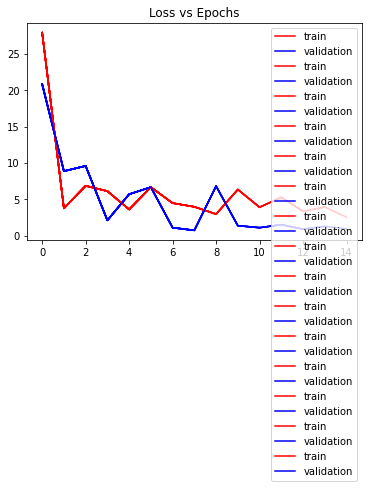

In [12]:
# model.load_state_dict(torch.load('/home/pkao/covid/UCSB_COVID/model_backup/epoch25_ResNet50.pt'))
from numpy import *
import math
import matplotlib.pyplot as plt
# train
bs = 10
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
#scheduler = StepLR(optimizer, step_size=1)

total_epoch = 15
train_loss_list = []
val_loss_list = []
for epoch in range(1, total_epoch+1):
    train_loss_list.append(train(optimizer, epoch))    
    targetlist, scorelist, predlist, val_loss = val(epoch)
    val_loss_list.append(val_loss)
#     print('target',targetlist)
#     print('score',scorelist)
#     print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 
#     print(predlist)

    # if epoch % votenum == 0:
    if True:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
#         AUC = roc_auc_score(targetlist, vote_score)
#         print('AUCp', roc_auc_score(targetlist, vote_pred))
#         print('AUC', AUC)
        
        
        
        if epoch%1 == 0:
            torch.save(model.state_dict(), "model_backup/epoch{}_{}.pt".format(epoch,modelname))  
        
            vote_pred = np.zeros(valset.__len__())
            vote_score = np.zeros(valset.__len__())
            print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}'.format(
            epoch, r, p, F1, acc))

            f = open('model_result/epoch{}_{}.txt'.format(modelname, epoch), 'w')
            f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}'.format(
            epoch, r, p, F1, acc))
            f.close()
            
            t = [i for i in range(len(val_loss_list))]
            train_loss_list_v2 = [x.cpu().item() for x in train_loss_list]
            plt.plot(t, train_loss_list_v2, 'r', label = "train") 
            val_loss_list_v2 = [x.cpu().item() for x in val_loss_list]
            plt.plot(t, val_loss_list_v2, 'b', label = "validation") 
            plt.legend()
            plt.title('Loss vs Epochs')
            plt.savefig(os.path.join('model_result/', str(epoch) + 'ResNet18.png'))

In [42]:
torch.save(model.state_dict(), "model_backup/epoch{}_{}.pt".format(25,modelname)) 

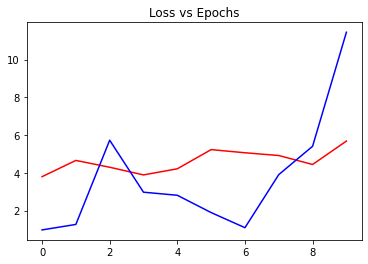

In [50]:
f = open('model_result/epoch{}_{}.txt'.format(modelname, epoch), 'w')
# f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}'.format(
# epoch, r, p, F1, acc))
f.close()

t = [i for i in range(len(val_loss_list_v2))]
plt.plot(t, train_loss_list_v2, 'r', label = "train") 
plt.plot(t, val_loss_list_v2, 'b', label = "validation") 
# plt.legend()
plt.title('Loss vs Epochs')
plt.savefig(os.path.join('model_result/', str(epoch) + 'ResNet152.png'))

In [ ]:
print(epoch)

In [ ]:
print(train_loss_list_v2)

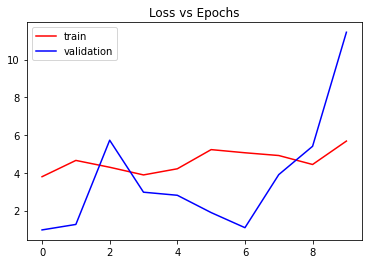

In [51]:
from numpy import *
import math
import matplotlib.pyplot as plt
t = [i for i in range(len(val_loss_list_v2))]
plt.plot(t, train_loss_list_v2, 'r', label = "train") 
plt.plot(t, val_loss_list_v2, 'b', label = "validation") 
plt.legend()
plt.title('Loss vs Epochs')
plt.savefig('books_read.png')

In [52]:
print(score)
#???

NameError: name 'score' is not defined

In [59]:
# device = 'cuda'
model.load_state_dict(torch.load('/home/kathy/model_backup/epoch25_ResNet50.pt'))
# test
bs = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scheduler = StepLR(optimizer, step_size=1)

total_epoch = 1
for epoch in range(1, total_epoch+1):
    
    targetlist, scorelist, predlist = test(epoch)
#     print('target',targetlist)
#     print('score',scorelist)
#     print('predict',predlist)
#     vote_pred = vote_pred + predlist 
#     vote_score = vote_score + scorelist 
    
    TP = ((predlist == 1) & (targetlist == 1)).sum()
    TN = ((predlist == 0) & (targetlist == 0)).sum()
    FN = ((predlist == 0) & (targetlist == 1)).sum()
    FP = ((predlist == 1) & (targetlist == 0)).sum()
     
    T0 = ((predlist == 0) & (targetlist == 0)).sum()
    T1 = ((predlist == 1) & (targetlist == 1)).sum()
    T2 = ((predlist == 2) & (targetlist == 2)).sum()

    print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
    print('TP+FP',TP+FP)
    p = TP / (TP + FP)
    print('precision',p)
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    print('recall',r)
    F1 = 2 * r * p / (r + p)
    acc = (T0 + T1 + T2) / 694
    print('F1',F1)
    print('acc',acc)
    print(T0, T1, T2)
    
    Wrong_Normal_1 = ((predlist == 1) & (targetlist == 2)).sum()
    Wrong_Normal_0 = ((predlist == 0) & (targetlist == 2)).sum()
    print("Normal wrong identified is", Wrong_Normal_1 + Wrong_Normal_0)
    Wrong_Covid_N = ((predlist == 2) & (targetlist == 0)).sum()
    Wrong_PNA_N = ((predlist == 2) & (targetlist == 1)).sum()
    print("Normal wrong identified is", Wrong_Covid_N + Wrong_PNA_N)
    Total_Normal = (targetlist == 2).sum()
    print("Total Normal ", Total_Normal)
    
    #confusion matrix
    print("confusion matrix")
    print (((predlist == 0) & (targetlist == 0)).sum())
    print(((predlist == 1) & (targetlist == 0)).sum())
    print(((predlist == 2) & (targetlist == 0)).sum())
    print(((predlist == 0) & (targetlist == 1)).sum())
    print(((predlist == 1) & (targetlist == 1)).sum())
    print(((predlist == 2) & (targetlist == 1)).sum())
    print(((predlist == 0) & (targetlist == 2)).sum())
    print(((predlist == 1) & (targetlist == 2)).sum())
    print(((predlist == 2) & (targetlist == 2)).sum())
    
    
#     AUC = roc_auc_score(targetlist, vote_score, multi_class="ovo", average="macro")
#     print('AUC', AUC)

#     if epoch % votenum == 0:
        
#         # major vote
#         vote_pred[vote_pred <= (votenum/2)] = 0
#         vote_pred[vote_pred > (votenum/2)] = 1
        
# #         print('vote_pred', vote_pred)
# #         print('targetlist', targetlist)
#         TP = ((vote_pred == 1) & (targetlist == 1)).sum()
#         TN = ((vote_pred == 0) & (targetlist == 0)).sum()
#         FN = ((vote_pred == 0) & (targetlist == 1)).sum()
#         FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
#         T0 = ((predlist == 0) & (targetlist == 0)).sum()
#         T1 = ((predlist == 1) & (targetlist == 1)).sum()
#         T2 = ((predlist == 2) & (targetlist == 2)).sum()
        
        
#         print(T0, T1, T2)
#         print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
#         print('TP+FP',TP+FP)
#         p = TP / (TP + FP)
#         print('precision',p)
#         p = TP / (TP + FP)
#         r = TP / (TP + FN)
#         print('recall',r)
#         F1 = 2 * r * p / (r + p)
#         acc = (T0 + T1 + T2) / 694
#         print('F1',F1)
#         print('acc',acc)
#         AUC = roc_auc_score(targetlist, vote_score, multi_class="ovo",average=None)
#         print('AUC', AUC)
        
        
#         f = open('model_result/{modelname}.txt', 'a+')
#         f.write('precision, recall, F1, acc= \n')
#         f.writelines(str(p))
#         f.writelines('\n')
#         f.writelines(str(r))
#         f.writelines('\n')
#         f.writelines(str(F1))
#         f.writelines('\n')
#         f.writelines(str(acc))
#         f.writelines('\n')
#         f.close()
        
        
#         vote_pred = np.zeros((1,testset.__len__()))
#         vote_score = np.zeros(testset.__len__())
#         print('vote_pred',vote_pred)
#         print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}'.format(
#         epoch, r, p, F1, acc))

#         f = open(f'model_result/test_{modelname}.txt', 'a+')
#         f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}'.format(
#         epoch, r, p, F1, acc))
#         f.close()


TP= 16 TN= 0 FN= 0 FP= 7
TP+FP 23
precision 0.6956521739130435
recall 1.0
F1 0.8205128205128205
acc 0.023054755043227664
0 16 0
Normal wrong identified is 0
Normal wrong identified is 0
Total Normal  0
confusion matrix
0
7
0
0
16
0
0
0
0


In [ ]:
print(predlist)

In [ ]:
print(targetlist)

In [ ]:
predlist = list(predlist)
print(predlist.count(0), predlist.count(1), predlist.count(2))#13PNA

In [ ]:
predlist = list(predlist)
print(predlist.count(0), predlist.count(1), predlist.count(2))

In [ ]:
predlist = list(predlist)
print(predlist.count(0), predlist.count(1), predlist.count(2))

In [ ]:
predlist = list(predlist)
print(predlist.count(0), predlist.count(1), predlist.count(2))

In [ ]:
predlist = list(predlist)
print(predlist.count(0), predlist.count(1), predlist.count(2))

In [ ]:
predlist = list(predlist)
print(predlist.count(0), predlist.count(1), predlist.count(2))

In [ ]:
predlist = list(predlist)
print(predlist.count(0), predlist.count(1), predlist.count(2))

In [ ]:
print(predlist)

In [ ]:
patients_COVID  = ['5PCQOVC5','5M9S0FLO','5PCPQBII','5M9S6CQS','5PCPSAK7','5PCP_6R0','5PCQE_3N']
patients_PNA = ['5PCPKEDE','5M9RJO6C','5PCP2MZ2','5PCOTRQK','5PCPAJ4W','5PCOHXGC','5PCOXPTZ']

In [ ]:
print(list(predlist[:322]).count(0), list(predlist[:322]).count(1), list(predlist[:322]).count(2))
print(list(predlist[322:]).count(0), list(predlist[322:]).count(1),list(predlist[322:]).count(2))

In [ ]:
print(list_images) 

In [ ]:
for names in patients_COVID:
    for i in range(len(list_images)):
        begin = list_images.index
        end = len(test_list) - 1 - test_list[::-1].index('e')  

In [ ]:
print(list_images)

In [ ]:
import os.path as osp
votenum = 10
device = 'cuda'
def test(epoch):
    global_counter = 0
    counter = 0
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []

        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            print(batch_index)
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            print(data.shape)
            data = data
            target = target
            print(target.shape)
    #            data = data[:, 0, :, :]
    #            data = data[:, None, :, :]
    #             print(target)
            target_layers = ["relu", "layer1", "layer2", "layer3", "layer4"]
            target_class = 0
            gcam = GradCAM(model=model)
            probs, ids = gcam.forward(data)
            ids_ = torch.FloatTensor([[target_class]] * len(data))
    #         var_ids_ = Variable(ids_.data, requires_grad = True).cuda()
            gcam.backward(ids=ids_)
            for target_layer in target_layers:
                print("Generating Grad-CAM @{}".format(target_layer))

                # Grad-CAM
                regions = gcam.generate(target_layer=target_layer)

                for j in range(len(data)):
    #                 print(
    #                     "\t#{}:  ({:.5f})".format(
    #                         j, float(probs[ids == target_class])
    #                     )
    #                 )

                    save_gradcam(
                        filename=osp.join(
                            './results',
                            "{}-{}-heatmap-{}.png".format(
                               str(list_images[global_counter//5][0].split('/')[7]), str(list_images[global_counter//5][1]), target_layer,
                            ),
                        ),
                        gcam=regions[j, 0],
                        raw_image=data[j],
                    )
                    global_counter += 1
            counter += 1
            output = model(data)
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
    #             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
    #             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
    #             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
    # #             # FN    predict 0 label 1
    #             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
    # #             # FP    predict 1 label 0
    #             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
    #             print(TP,TN,FN,FP)


    #             print(output[:,1].cpu().numpy())
    #             print((output[:,1]+output[:,0]).cpu().numpy())
    #             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.detach().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)

    return targetlist, scorelist, predlist
    
    

In [ ]:
import matplotlib.cm as cm
import cv2
def save_gradcam(filename, gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap 
    else:
        b = ((raw_image.numpy().T * std) + mean)*255
        
    
        gcam = (np.flip(ndimage.rotate(cmap.astype(np.float), 90, reshape=True),0) + b.astype(np.float)) / 2
    cv2.imwrite(filename, np.uint8(gcam))
#     cv2.imwrite('img '+ filename, np.uint8(b.astype(np.float)*255))

In [ ]:
def get_device(cuda):
    cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    if cuda:
        current_device = torch.cuda.current_device()
        print("Device:", torch.cuda.get_device_name(current_device))
    else:
        print("Device: CPU")
    return device

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
from scipy import ndimage, misc
# classes = get_classtable()
from collections import Sequence
from torch.autograd import Variable
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm

class _BaseWrapper(object):
    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)

        one_hot.scatter_(1, ids.type('torch.LongTensor'),1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:]
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()


class BackPropagation(_BaseWrapper):
    def forward(self, image):
        self.image = image.requires_grad_()
        return super(BackPropagation, self).forward(self.image)

    def generate(self):
        gradient = self.image.grad.clone()
        self.image.grad.zero_()
        return gradient


class GuidedBackPropagation(BackPropagation):
    """
    "Striving for Simplicity: the All Convolutional Net"
    https://arxiv.org/pdf/1412.6806.pdf
    Look at Figure 1 on page 8.
    """

    def __init__(self, model):
        super(GuidedBackPropagation, self).__init__(model)

        def backward_hook(module, grad_in, grad_out):
            # Cut off negative gradients
            if isinstance(module, nn.ReLU):
                return (F.relu(grad_in[0]),)

        for module in self.model.named_modules():
            self.handlers.append(module[1].register_backward_hook(backward_hook))


class Deconvnet(BackPropagation):
    """
    "Striving for Simplicity: the All Convolutional Net"
    https://arxiv.org/pdf/1412.6806.pdf
    Look at Figure 1 on page 8.
    """

    def __init__(self, model):
        super(Deconvnet, self).__init__(model)

        def backward_hook(module, grad_in, grad_out):
            # Cut off negative gradients and ignore ReLU
            if isinstance(module, nn.ReLU):
                return (F.relu(grad_out[0]),)

        for module in self.model.named_modules():
            self.handlers.append(module[1].register_backward_hook(backward_hook))


class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        def save_fmaps(key):
            def forward_hook(module, input, output):
                self.fmap_pool[key] = output.detach()

            return forward_hook

        def save_grads(key):
            def backward_hook(module, grad_in, grad_out):
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam


def occlusion_sensitivity(
    model, images, ids, mean=None, patch=35, stride=1, n_batches=128
):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure A5 on page 17
    Originally proposed in:
    "Visualizing and Understanding Convolutional Networks"
    https://arxiv.org/abs/1311.2901
    """

    torch.set_grad_enabled(False)
    model.eval()
    mean = mean if mean else 0
    patch_H, patch_W = patch if isinstance(patch, Sequence) else (patch, patch)
    pad_H, pad_W = patch_H // 2, patch_W // 2

    # Padded image
    images = F.pad(images, (pad_W, pad_W, pad_H, pad_H), value=mean)
    B, _, H, W = images.shape
    new_H = (H - patch_H) // stride + 1
    new_W = (W - patch_W) // stride + 1

    # Prepare sampling grids
    anchors = []
    grid_h = 0
    while grid_h <= H - patch_H:
        grid_w = 0
        while grid_w <= W - patch_W:
            grid_w += stride
            anchors.append((grid_h, grid_w))
        grid_h += stride

    # Baseline score without occlusion
    baseline = model(images).detach().gather(1, ids)

    # Compute per-pixel logits
    scoremaps = []
    for i in tqdm(range(0, len(anchors), n_batches), leave=False):
        batch_images = []
        batch_ids = []
        for grid_h, grid_w in anchors[i : i + n_batches]:
            images_ = images.clone()
            images_[..., grid_h : grid_h + patch_H, grid_w : grid_w + patch_W] = mean
            batch_images.append(images_)
            batch_ids.append(ids)
        batch_images = torch.cat(batch_images, dim=0)
        batch_ids = torch.cat(batch_ids, dim=0)
        scores = model(batch_images).detach().gather(1, batch_ids)
        scoremaps += list(torch.split(scores, B))

    diffmaps = torch.cat(scoremaps, dim=1) - baseline
    diffmaps = diffmaps.view(B, new_H, new_W)

    return diffmaps
# test
bs = 10
import warnings
warnings.filterwarnings('ignore')
device = get_device(0)
r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scheduler = StepLR(optimizer, step_size=1)

total_epoch = 1
for epoch in range(1, total_epoch+1):
    
    targetlist, scorelist, predlist = test(epoch)
#     print('target',targetlist)
#     print('score',scorelist)
#     print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 
    
    TP = ((predlist == 1) & (targetlist == 1)).sum()
    TN = ((predlist == 0) & (targetlist == 0)).sum()
    FN = ((predlist == 0) & (targetlist == 1)).sum()
    FP = ((predlist == 1) & (targetlist == 0)).sum()

    print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
    print('TP+FP',TP+FP)
    p = TP / (TP + FP)
    print('precision',p)
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    print('recall',r)
    F1 = 2 * r * p / (r + p)
    acc = (TP + TN) / (TP + TN + FP + FN)
    print('F1',F1)
    print('acc',acc)
    AUC = roc_auc_score(targetlist, vote_score)
    print('AUC', AUC)

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        
#         print('vote_pred', vote_pred)
#         print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUC', AUC)
        
        
        f = open('model_result/{modelname}.txt', 'a+')
        f.write('precision, recall, F1, acc= \n')
        f.writelines(str(p))
        f.writelines('\n')
        f.writelines(str(r))
        f.writelines('\n')
        f.writelines(str(F1))
        f.writelines('\n')
        
        f.writelines(str(acc))
        f.writelines('\n')
        f.close()
        
        
        vote_pred = np.zeros((1,testset.__len__()))
        vote_score = np.zeros(testset.__len__())
        print('vote_pred',vote_pred)
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

        f = open(f'model_result/test_{modelname}.txt', 'a+')
        f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))
        f.close()


In [ ]:
print(ids_.device)

In [ ]:
model.load_state_dict(torch.load('/home/pkao/covid/UCSB_COVID/model_backup/epoch10_ResNet152.pt'))

In [ ]:
import matplotlib.cm as cm
import cv2
def save_gradcam(filename, gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap 
    else:
        b = ((raw_image.numpy().T * std) + mean)*255
        
    
        gcam = (np.flip(ndimage.rotate(cmap.astype(np.float), 90, reshape=True),0) + b.astype(np.float)) / 2
        
        
#         b = (raw_image.numpy().T ) *255
#         print(b.any)
    
#         gcam = (b.astype(np.float)) / 2
    cv2.imwrite(filename, np.uint8(gcam))
#     cv2.imwrite('img '+ filename, np.uint8(b.astype(np.float)*255))  np.flip(ndimage.rotate(cmap.astype(np.float), 90, reshape=True),0) + 

In [ ]:
def get_device(cuda):
    cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    if cuda:
        current_device = torch.cuda.current_device()
        print("Device:", torch.cuda.get_device_name(current_device))
    else:
        print("Device: CPU")
    return device
device = get_device(1)

In [ ]:
# print(list_images)
global_counter = 1
print(str(list_images[global_counter//5][0].split('/')[7]))

In [ ]:
import os.path as osp

def test(epoch):
    counter = 0
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
#     with torch.no_grad():
    tpr_list = []
    fpr_list = []

    predlist=[]
    scorelist=[]
    targetlist=[]
    # Predict
    for batch_index, batch_samples in enumerate(test_loader):
        print(batch_index)
        data, target = batch_samples['img'], batch_samples['label']
        print(data.shape)
        data = data
        target = target
        print(target.shape)
#            data = data[:, 0, :, :]
#            data = data[:, None, :, :]
#             print(target)
        target_layers = ["relu", "layer1", "layer2", "layer3", "layer4"]
        target_class = 0
        gcam = GradCAM(model=model)
        probs, ids = gcam.forward(data)
        ids_ = torch.FloatTensor([[target_class]] * len(data))
#         var_ids_ = Variable(ids_.data, requires_grad = True).cuda()
        gcam.backward(ids=ids_)
        for target_layer in target_layers:
            print("Generating Grad-CAM @{}".format(target_layer))

            # Grad-CAM
            regions = gcam.generate(target_layer=target_layer)

            for j in range(len(data)):
#                 print(
#                     "\t#{}:  ({:.5f})".format(
#                         j, float(probs[ids == target_class])
#                     )
#                 )

                save_gradcam(
                    filename=osp.join(
                        './results',
                        "{}-{}-heatmap-{}.png".format(
                           str(list_images[global_counter//5][0].split('/')[7]), str(list_images[global_counter//5][1]), target_layer,
                        ),
                    ),
                    gcam=regions[j, 0],
                    raw_image=data[j],
                )
                global_counter += 1
        counter += 1
        output = model(data)
        test_loss += criteria(output, target.long())
        score = F.softmax(output, dim=1)
        print(score)
        pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
        correct += pred.eq(target.long().view_as(pred)).sum().item()
#             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
#             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
# #             # FN    predict 0 label 1
#             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
# #             # FP    predict 1 label 0
#             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
#             print(TP,TN,FN,FP)


#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
        targetcpu=target.long().cpu().numpy()
        predlist=np.append(predlist, pred.cpu().numpy())
        scorelist=np.append(scorelist, score.detach().numpy()[:,1])
        targetlist=np.append(targetlist,targetcpu)
           
    return targetlist, scorelist, predlist
    

In [ ]:
import matplotlib
img = matplotlib.pyplot.imread()

In [ ]:
matplotlib.pyplot.imshow(img)

In [ ]:
image = Image.open('/home/pkao/covid/Covid_ucsb/Images-processed/CT_COVID/5M9RRKD5_slice_4.png').convert('RGB')

In [ ]:
print(img.shape)

In [ ]:
print(img[150][250])

In [ ]:
print(image)

In [ ]:
image = nib.load('/media/pkao/Dataset/COVIDDataset/MaskedCOVIDSlices/5M9RVIGK_slice_23.nii')
image = image.get_fdata()
data = image
rescaled = (255.0 / data.max() * (data - data.min())).astype(np.uint8)
image = Image.fromarray(np.asarray(rescaled))

In [ ]:
print(image)

In [ ]:
image.show()

In [ ]:
print(model)

In [ ]:
# Python program to read image using OpenCV 
  
# importing OpenCV(cv2) module 
import cv2 
  
# Save image in set directory 
# Read RGB image 
img = cv2.imread('/media/pkao/Dataset/COVIDDataset/4/COVID-19 (11)/IMG-0341-00046.jpg')  
  
# Output img with window name as 'image' 
cv2.imshow('image', img)  
  
# Maintain output window utill 
# user presses a key 
cv2.waitKey(0)         
  
# Destroying present windows on screen 
cv2.destroyAllWindows() 